<h1> <center> ENSF 519.01 Applied Data Scince </center></h1>
<h2> <center> Assignment 3: Supervised learning and dimension reduction (25 marks)</center></h2>
<h2> <center> Due: March 9, 2018. To be submitted on D2L Dropbox </center></h2>


In this assignment the focus is on ensemble models for learning and how preprocessing can help improving prediction scores. There are 5 parts that each may use different dataset. All datasets are available as csv files on D2L. 

<h2>Part A. Defect Prediction - Voting Ensemble Model (4 marks)</h2>
<br><br>
In this section you need to repeat what you did in your last assignment, HW2 at Part C, but this time you should use VotingClassifier function of SKlearn rather than the Combine function explained in that assignment.
<br>
Basically, you predict defects on the same NASA dataset using a simple ensemble model consisting of Logistic Regression, Gaussian Naive Bayes, and K-Nearest Neighbor estimators. You need to try both "soft voting" and "hard voting" options. 
<br>
All models and functions should be called by their default parameters.
<br>
Same as HW2, you calculate each combined score 30 times (with different random_state seeds for the train_test_splits).
Finally, visualize the results as three boxplots of 30 runs per: a) soft voting, b) hard voting, and c) your combined model’s results from HW2.

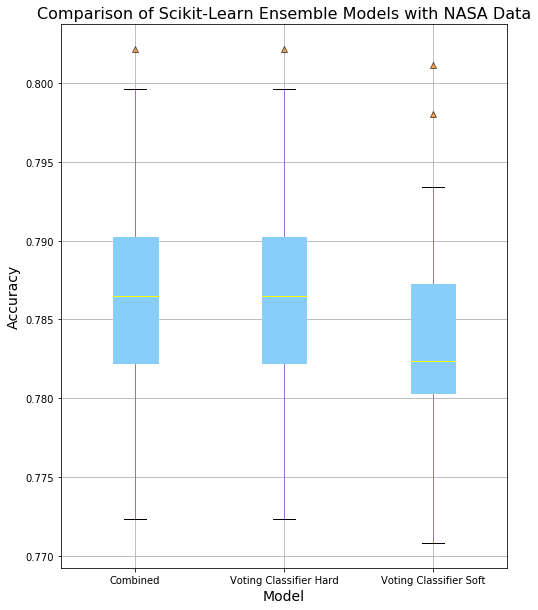

In [1]:
# pandas v0.22.0
import pandas as pd

# numpy v1.13.3
import numpy as np

# sklearn v0.19.1
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

# matplotlib v2.1.2
import matplotlib.pyplot as plt
%matplotlib inline


# Load File
nasa_path = "NasaData.csv"
try:
    nasa_df = pd.read_csv(nasa_path)
except FileNotFoundError as e:
    print(e)


#
# Simple Ensemble Models
#
def get_ensemble_scores(count, tuning):
    """
    Make `count` ensemble predictions and return the scores in a list.
    """
    p = []
    vc = VotingClassifier(
        estimators = [
            ('lr', LogisticRegression()),
            ('gnb', GaussianNB()),
            ('knn', KNeighborsClassifier())
        ],
        **tuning
    )
    
    for seed in range(1, count + 1):
        # take 75% of data as training set and 25% of as test set
        X_train, X_test, y_train, y_test = train_test_split(
            nasa_df.drop('label', axis=1), nasa_df['label'], test_size=0.25, random_state=seed)
        # predict label: defective (1) or not defective (0)
        vc.fit(X_train, y_train)
        p.append(vc.score(X_test, y_test))
    return p


#
# Combined Model (Assignment 2)
#
def combine(model_1, model_2, model_3, count):
    """
    Generates a weighted prediction from 3 models.
    -- Borrowed from Assignment 2 --
    """
    scores = []
    for seed in range(1, count + 1):
        vote_df = pd.DataFrame()
        for m in [model_1, model_2, model_3]:
            model = m()
            # take 75% of data as training set and 25% of as test set
            X_train, X_test, y_train, y_test = train_test_split(
                nasa_df.drop('label', axis=1), nasa_df['label'], test_size=0.25, random_state=seed)
            # train model
            model.fit(X_train, y_train)
            # predict class and probability
            preds = model.predict(X_test)
            probs = model.predict_proba(X_test)
            # calcuate weighted vote
            votes = []
            for i, p in enumerate(preds):
                if p == 1:
                    votes.append(probs[i][1])
                elif p == 0:
                    votes.append(-1 * probs[i][0])
                else:
                    raise RuntimeError("Invalid prediction class, ", p)
            vote_df[m.__name__ + '_v'] = votes

        # average the votes from each model and round to 0 or 1 for combined prediction
        y_pred = vote_df.mean(axis=1).apply(np.ceil).apply(np.absolute)
        
        # score prediction
        scores.append(accuracy_score(y_test, y_pred))
    return scores


#
# Predict and Score
#
run_count = 30
model_dist_df = pd.DataFrame({ "Voting Classifier Hard":get_ensemble_scores(run_count, {"voting":"hard"}),
                               "Voting Classifier Soft":get_ensemble_scores(run_count, {"voting":"soft"}),
                               "Combined":combine(LogisticRegression, GaussianNB, KNeighborsClassifier, run_count) })


#
# Boxplots
#
ax = model_dist_df.plot.box(
    figsize=(8, 10),
    grid=True,
    patch_artist=True,
    flierprops={'markerfacecolor': '#ff7f00', 'marker': '^', 'alpha': 0.6},
    color=dict(boxes='lightskyblue', whiskers='mediumpurple', medians='yellow')
)
ax.set_title('Comparison of Scikit-Learn Ensemble Models with NASA Data')
ax.title.set_fontsize(16)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.yaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontsize(14)

<h2>Part B. Linear Regression, Random Forest, and Gradient Boosting (5 marks) </h2>

In this section, our task is again defect prediction. However, this time each artifact may have zero, one, or more defects. Thus our job is not just predicting defective vs. non-defective targets, but we would like to predict the exact number of defects. This is useful since one can prioritize QA effort based on the number of defects as a sign of severity. To do so we treat the problem as a regression problem not a classification problem.

- <b> If we would use a classification rather than regression, explain what kind of classification problem this question could fit in and why? Explain why a regression solution is a better choice.



<b>Your Answer:</b> ...................

To build your models you should follow these steps: 
<br>
- read the data from "OO-DefectPrediction.csv" 

- apply a basic linear regression. (with all default parameters)

- apply random forest regression. (with all default parameters, that is e.g., n_estimators=10, etc.)

- apply gradient boosting regression. (with all default parameters, that is e.g., n_estimators=100, etc.)

- calculate all R^2s. Note: You should implement R^2s as follows: 
  - round each predicted value (y_pred) to create your rounded_y_pred (e.g., 1.6 --> 1 and 0.4 --> 0)
  - call sklearn.metrics.r2_score with (y_true, rounded_y_pred)


- Run each model 30 times, with a new train test split. Set random_state to range(1,30) every time you create a train-test set. Also use the same seed value ([1..30]) for the corresponding RandomForestRegressor and GradientBoostingRegressor's  random_state parameter. Keep the test set size as default. 

- Finally, print the median score of those 30 runs for the three models, on the test set.




In [2]:
#
# Note: Read Part C since it builds on this part
#

<h2>Part C. Improving regression by tuning (5 marks)</h2>
<br><br>
In this part, we want to improve the R^2's achieved by the default setups, in Part B. To reduce the scope of the assignment we only focus on RandomForestRegressor, in this part. We approach the problem by tuning the RandomForestRegressor's main parameters (max_depth, and n_estimators).

You first need to apply RandomForestRegressor with different values of max_depth as [3,4,5,6,7,None] (None means no maximum). n_estimators should be tested with this values [10,20,30,...,100]. 

Keep other parameters of RandomForestRegressor the same as Part B. 

Run each configuration 30 times (with random seeds [1..30]) and calculate the median R^2 per configuration. 

Find the best configuration of n_estimators and max_depth among the ones you tested, with the highest median R^2. 

Report the best configuration you found by printing the max_depth, the n_estimators, and the resulting median R^2.

How much improvement you achieved compared to the default set up of RandomForestRegressor in Part B?


In [3]:
#
# Part E will use the same dataset as this part (but I don't "think" it builds on it)
#

<h1>Part D. Dimension reduction - feature selection (7 marks)</h1>
<br><br>

In this section, we want to compare the dimension reduction ability of PCA with linear regression models. 

To use linear regression model as a dimension reduction technique, we fit the model and pick the most informative features and represent the data with only those features. 

Our dataset is "ApacheAll.csv", which records some performance measurements of an APACHE Web Server, which have been collected using a standard benchmark. See https://zenodo.org/record/322483#.WoZap5PwaRv for more details about the dataset.

<br>
Steps:  
- Apply Linear Regression on "ApacheAll.csv" data and find the coefficient of each feature and pick the two greatest ones. Reduce the dimensionality of your dataset by only keeping these two features in your train and test set.
    - use default parameters.
- Fit a PCA model on the original training set and pick the first two principal components (which contains most of the variations). Transform both training and test sets to this new space (2 dimensions).
    - use default parameters.  
    
- Build 3 random forest regression models: a) use the train and test set given by linear regression selected features, b) use PCA transformed data, c) use the original training and test sets.
    
    
- repeat the above three steps 30 times with random_state range [1..30] for both train/test splitter and RandomForestRegressor. Note that for each run a new PCA and Linear regression should be applied (i.e., do not transform new data based on the old fitted models)

- For all three models 
    - print the median regression scores (over 30 runs) 

- Explain your observation with respect to relative performance of PCA and linear regression for dimension reduction and why this has happened.

<h1>Part E. Dimension reduction for visualization (4 marks)</h1>

One of the main use cases of dimensionality reduction techniques is for visualization of high dimensional datasets.
In this part, we use the same OO-DefectPrediction.csv dataset and visualize it in just two dimensions.

Steps :

- Read the data from "OO-DefectPrediction.csv".
- Transform the data to principal components using pca. 
- visualize data using the two first principal components. You should use different color code to visualize number of bugs. 
- explain your observations.
